### Gene length

In [ ]:
import time
import timeit
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm
from scipy.stats import mannwhitneyu
from collections import defaultdict

# transparent background
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  
})

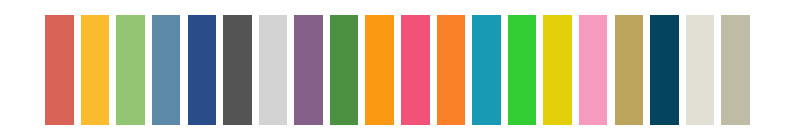

In [2]:
# define colors
purple = '#856088'
pink = '#F25278'
red = '#d96256'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#284d88'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
lightyellow = '#e4d00a'
lightgreen2 = '#32CD32'
lightblue2 = '#189AB4'
darkblue2 = '#05445E'
lightpink = '#F79AC0'
darkorange2 = '#FA8128'
darkyellow = '#BDA55D'
lightgray2 = '#E2E0D4'
lightgray3 = '#BFBBA4'

colors = [
    red, lightorange, lightgreen, lightblue, darkblue, 
    darkgray, lightgray, purple, darkgreen, darkorange,
    pink, darkorange2, lightblue2, lightgreen2, lightyellow,
    lightpink, darkyellow, darkblue2, lightgray2, lightgray3
]

plt.figure(figsize=(10, 1.5))
plt.bar(range(len(colors)), height=1, color=colors)
__ = plt.axis('off')

#### load data

In [4]:
# mouse gene len
mouse_gene_len = pd.read_csv('input/mm10_gene_len.txt', sep='\t')

In [5]:
# convert mouse ensembl using https://www.biotools.fr/mouse/ensembl_symbol_converter
# (mygene not working for mouse ensembl)

# ensembl gene to txt
gene_ensembl = mouse_gene_len.gene.tolist()
path = f'input/gene_ensembl.txt'
with open(path, 'w') as outfile:
    outfile.write("\n".join(gene_ensembl))

# load ensembl-gene pairs from web server
ensemble2gene = pd.read_csv('input/ensemble2gene.txt', sep=' ', header=None)

In [6]:
# add geneID to tables
mouse_gene_len['geneID'] = ensemble2gene[2]
mouse_gene_len.head(3)

,gene,mean,median,longest_isoform,merged,geneID
0,ENSMUSG00000064842,110,110,110,110,Gm26206
1,ENSMUSG00000051951,3592,3634,4153,6094,Xkr4
2,ENSMUSG00000089699,250,250,250,250,Gm1992


In [7]:
# load ella seqscope results
fn = '../ella/output_ella/ella_seqscope.pkl'
res_dict = pd.read_pickle(fn)
types_list = res_dict['types_list']
genes_dict = res_dict['genes_dict']
cells_dict = res_dict['cells_dict']
p_fdr_dict = res_dict['p_fdr_dict']
score_dict = res_dict['score_dict']
lam_dict = res_dict['lam_dict']
label_dict = res_dict['label_dict']
del res_dict

In [8]:
# for each type, create df with cols of 
# gene, pv, score, length, cluster_label
# invalid length is coded with -1
gene_len = mouse_gene_len # <<<
df_dict = {}

for t in tqdm(types_list):
    
    # find gene length
    data = genes_dict[t]
    keys = gene_len.geneID.tolist()
    vals = gene_len[['mean','median','longest_isoform','merged']].to_numpy().tolist()
    memo = defaultdict(lambda: (-1, -1, -1, -1, -1))
    for k, v in zip(keys, vals):
        if k not in memo:
            memo[k] = v
        else:
            #raise ValueError('duplicated keys')
            #print(f'duplicated keys k={k} v={v}')
            #memo[k] = v
            pass

    res0 = np.array(list(map(lambda x: memo[x][0], data)))
    res1 = np.array(list(map(lambda x: memo[x][1], data)))
    res2 = np.array(list(map(lambda x: memo[x][2], data)))
    res3 = np.array(list(map(lambda x: memo[x][3], data)))
    
    # make a df
    df_t = pd.DataFrame({
        'gene': genes_dict[t],
        'pv': p_fdr_dict[t],
        'score': score_dict[t],
        'label': label_dict[t],
        'len_mean': res0,
        'len_median': res1,
        'len_longest_isoform': res2,
        'len_merged': res3,
    })
    
    # add to dict
    df_dict[t] = df_t

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.09it/s]


In [9]:
# remove the invalid gene len
df2_dict = {}
for t in types_list:
    df_t = df_dict[t]
    df2_dict[t] = df_t[df_t.len_mean > 0]

In [10]:
len_types = ['len_mean', 'len_median', 'len_longest_isoform', 'len_merged']

#### all types together

In [11]:
# merged df
merged_df = pd.concat(df2_dict.values(), ignore_index=True)
merged_df.head(3)

,gene,pv,score,label,len_mean,len_median,len_longest_isoform,len_merged
0,Alb,0.000458,0.595768,2,2043,2043,2043,2043
1,Apoe,0.000525,0.595768,2,864,816,1386,1980
2,Ttr,1.000000,0.565525,-1,1219,1219,1219,1219


In [12]:
p12 = []
p13 = []
for l in len_types:
    print(f'----------{l}')
    # wilcoxon cluster 1 vs 2-5 
    sample1 = merged_df[l][(merged_df.label==0)].values
    sample2 = merged_df[l][(merged_df.label==1)|(merged_df.label==2)|(merged_df.label==3)|(merged_df.label==4)].values
    __statistic, p_value1 = mannwhitneyu(sample1, sample2)
    p12.append(p_value1)
    print(f'1 vs 2-5 \np={p_value1}')
    print(f'fc={np.mean(sample1)/np.mean(sample2)}')
    # wilcoxon cluster 1 vs all else
    sample3 = merged_df[l][(merged_df.label==-1)|(merged_df.label==1)|(merged_df.label==2)|(merged_df.label==3)|(merged_df.label==4)].values
    __statistic, p_value2 = mannwhitneyu(sample1, sample3)
    p13.append(p_value2)
    print(f'1 vs others \np={p_value2}')
    print(f'fc={np.mean(sample1)/np.mean(sample3)}')

----------len_mean
1 vs 2-5 
p=0.0005910293473973484
fc=1.4789770363118513
1 vs others 
p=0.019180865857126583
fc=1.2697064626814432
----------len_median
1 vs 2-5 
p=0.09032082926081626
fc=1.3495470093175979
1 vs others 
p=0.2941872485428545
fc=1.1887969557590128
----------len_longest_isoform
1 vs 2-5 
p=1.3867706563911008e-06
fc=1.876118066809501
1 vs others 
p=0.004345257808104888
fc=1.4193988654744618
----------len_merged
1 vs 2-5 
p=2.2223267912872341e-07
fc=1.7712089740181247
1 vs others 
p=0.006444170099753211
fc=1.2781693729499615


In [13]:
# bar plot
means = [
    (merged_df.len_mean)[merged_df.label==0].mean(),
    (merged_df.len_mean)[(merged_df.label!=0)&(merged_df.label!=-1)].mean(),
    (merged_df.len_mean)[merged_df.label!=-1].mean(),
    
    (merged_df.len_median)[merged_df.label==0].mean(),
    (merged_df.len_median)[(merged_df.label!=0)&(merged_df.label!=-1)].mean(),
    (merged_df.len_median)[merged_df.label!=-1].mean(),

    (merged_df.len_longest_isoform)[merged_df.label==0].mean(),
    (merged_df.len_longest_isoform)[(merged_df.label!=0)&(merged_df.label!=-1)].mean(),
    (merged_df.len_longest_isoform)[merged_df.label!=-1].mean(),
    
    (merged_df.len_merged)[merged_df.label==0].mean(),
    (merged_df.len_merged)[(merged_df.label!=0)&(merged_df.label!=-1)].mean(),
    (merged_df.len_merged)[merged_df.label!=-1].mean(),
]

# Individual data points for each category
data_points = [
    (merged_df.len_mean)[merged_df.label==0],
    (merged_df.len_mean)[(merged_df.label!=0)&(merged_df.label!=-1)],
    (merged_df.len_mean)[merged_df.label!=-1],
    
    (merged_df.len_median)[merged_df.label==0],
    (merged_df.len_median)[(merged_df.label!=0)&(merged_df.label!=-1)],
    (merged_df.len_median)[merged_df.label!=-1],
    
    (merged_df.len_longest_isoform)[merged_df.label==0],
    (merged_df.len_longest_isoform)[(merged_df.label!=0)&(merged_df.label!=-1)],
    (merged_df.len_longest_isoform)[merged_df.label!=-1],
    
    (merged_df.len_merged)[merged_df.label==0],
    (merged_df.len_merged)[(merged_df.label!=0)&(merged_df.label!=-1)],
    (merged_df.len_merged)[merged_df.label!=-1],
]

# remove outliers
lbs = []
ubs = []
data_points2 = []
for j in range(len(data_points)):
    data_j = data_points[j]
    
    # IQR
    Q1 = np.percentile(data_j, 25)
    Q3 = np.percentile(data_j, 75)
    # IQR = Q3 - Q1
    lower_bound = Q1
    upper_bound = Q3
    lbs.append(means[j]-lower_bound)
    ubs.append(upper_bound-means[j])
    
    data_j2 = data_j[(data_j >= lower_bound) & (data_j <= upper_bound)]
    
    data_points2.append(data_j2)

In [14]:
def sig_symb(p_value):
    if p_value <= 0.001:
        sig_symbol = '***'
    elif p_value <= 0.01:
        sig_symbol = '**'
    elif p_value <= 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    return sig_symbol

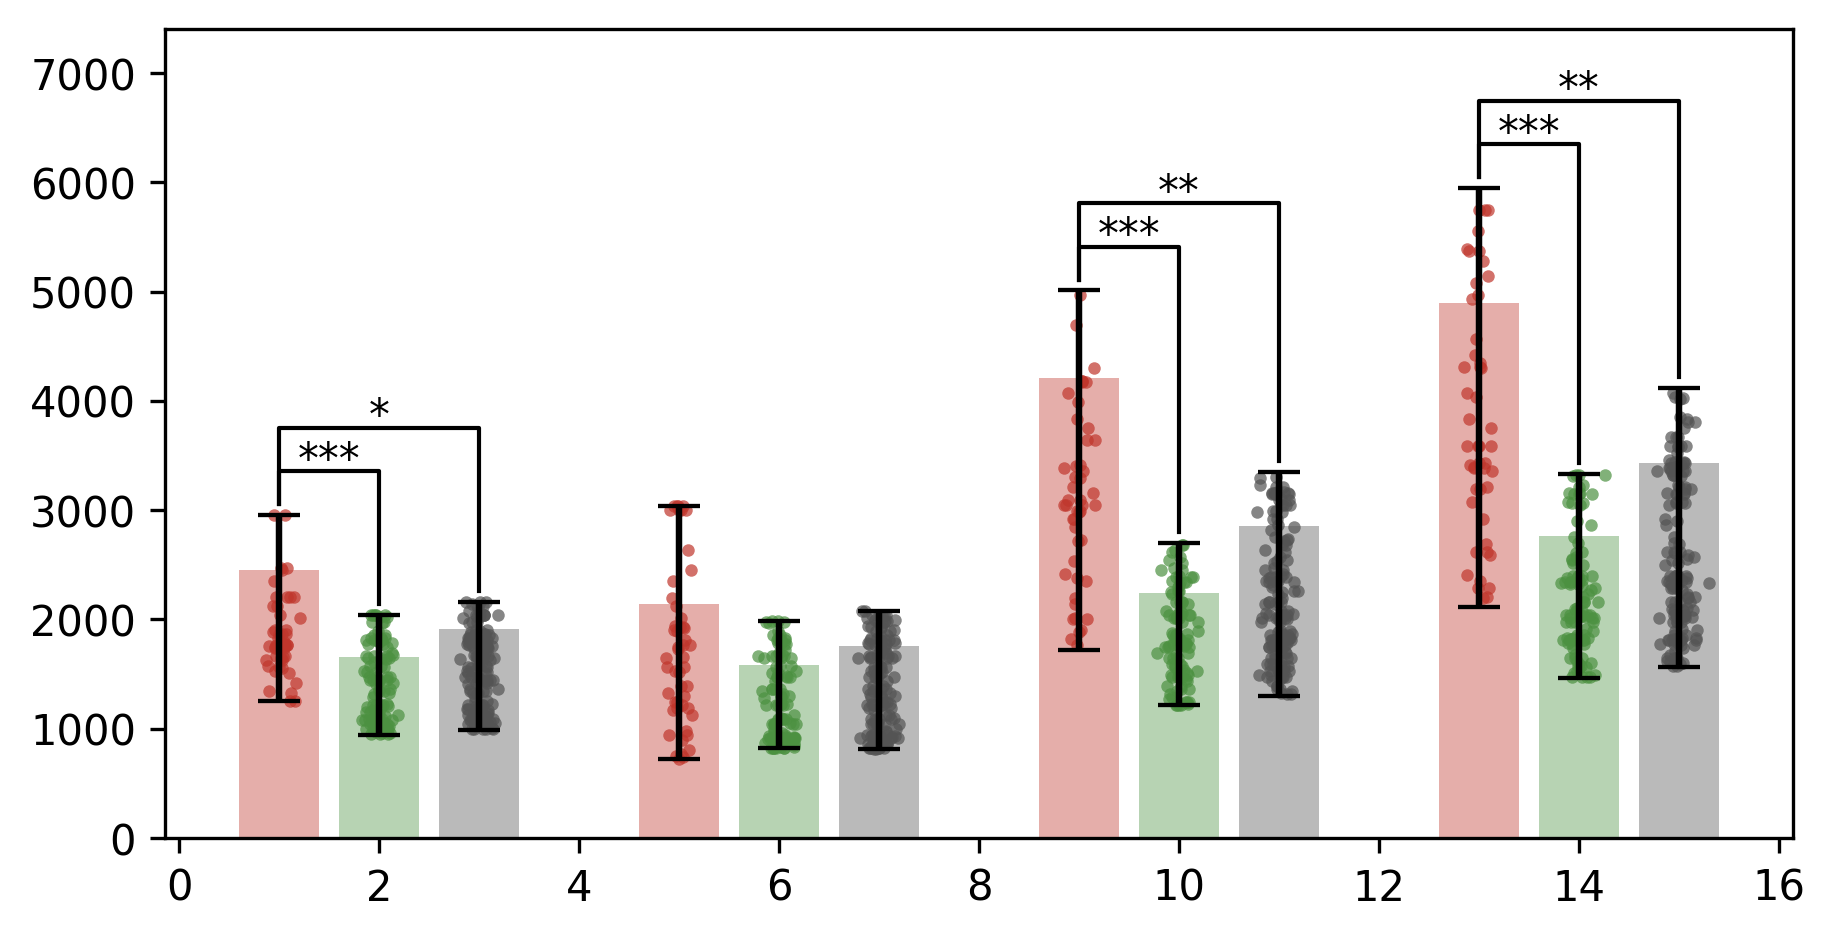

In [15]:
nr = 1
nc = 1
ss_nr = 3.5
ss_nc = 7
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

colors = [red, darkgreen, darkgray]*4
bar_pos = np.array([1,2,3, 5,6,7, 9,10,11, 13,14,15])

# bar
bars = ax.bar(bar_pos, means, yerr=np.array([lbs, ubs]), 
              capsize=5, 
              color=colors,
              zorder=1,
              alpha=0.4)
# the std 
bars = ax.bar(bar_pos, means, yerr=np.array([lbs, ubs]), 
              capsize=5, 
              zorder=3,
              alpha=0)

# Define the width of the spread
width = bars[0].get_width() / 1.0

# Adding spread dots
for _i, (i, data) in enumerate(zip(bar_pos, data_points2)):
    # Spread dots around the center of the bar
    x = np.random.normal(i, width/10, size=len(data))
    ax.plot(x, data, '.', 
            color=colors[_i], 
            markeredgewidth=0, mec='none', alpha=0.7, zorder=1)

# add 1 vs 2-5 pv
hgap_big = 400
hgap_small = 100
for j, p in enumerate(p12[:]):
    x1 = bar_pos[::3][j]
    x2 = x1+1
    bar1_max = means[j*3]+ubs[j*3]
    bar2_max = means[j*3+1]+ubs[j*3+1]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_small, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_small],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')
    
# add 1 vs others pv
hgap_big = 400*2
hgap_small = 100
for j, p in enumerate(p13[:]):
    x1 = bar_pos[::3][j]
    x2 = x1+2
    bar1_max = means[j*3]+ubs[j*3]
    bar2_max = means[j*3+2]+ubs[j*3+2]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_small, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_small],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')
    
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_ylim((0, 7400))

# plt.savefig(f'figs/fig_genelen_all.pdf', dpi=300, bbox_inches='tight')